# University of Maryland Center for Advanced Lifecycle Engineering
## Applications of Big Data in Prognostics & Health Management

![calce Logo](http://www.calce.umd.edu/images/CALCE_RED.gif)


## Analysis of the 2008 PHM Data Set Using Python with Spark

### Presented by John Patanian, Principal Engineer GE Power
### November 26, 2017

## Abstract
The purpose of this Jupyter notebook is to demonstrate a typical anomaly detection of an using industrial time series data using the standard scientific Python tools stack. This will serve as a baseline comparison to the Apache Spark version, which can scale to a much larger than memory data set.
The dataset comes from the 2008 PHM Data Challenge, and consists a dataset of multiple parameters from a jet engine. The dataset includes data from several jet engines of a similar design and includes data for three different settings, as well as about 21 sensor readings.

For more information on the dataset, please refer to PHM 2008 Data Challenge Data Set Documentation.
In this notebook, we will do pre-processing of the data using the scientific Python stack, which includes pandas, numpy and matplotlib. This will provide exposure to several data preprocessing an analysis techniques that are commonly applies to analyses in the context of a PHM application.

## Prerequisites

This notebook assumes you already have a local version of Spark installed on your computer. In order for the Jupyter Notebook to be ** *Spark Aware* **, you can either use options to automatically start up a Jupyter Notebook when you start the pySpark shell or you can manually set a few environment and path variables. This can either be done at the top of the Notebook, in a .bashrc or .bash_profile file (OS-X or Linux), or in a shell script or batch file.

Also, the [Anaconda Distribution](https://www.anaconda.com/download) must be installed for this tutorial

Directions from the [Apache Spark in Python: Beginner's Guide](https://www.datacamp.com/community/tutorials/apache-spark-python) should get you started on getting Spark and python working on your computer.

Create a directory where you want to start working and use the pyspark shell command with options to start with a Jupyter Notebook.

`PYSPARK_DRIVER_PYTHON="jupyter" PYSPARK_DRIVER_PYTHON_OPTS="notebook" pyspark`

## Data Set Description

The data set is in text file format, with spaces used to separate the columns. The data set includes no headers. Column names are defined in the data set documentation, and are shown below for reference.

Variables | Description
----------|------------
unit | Asset Identification
cycle_num | Time or flight based ordinal
setting1 | Unknown Operational setting 
setting2 | Unknown Operational setting 
setting3 | Unknown Operational setting 
sensor1 | Sensor time series reading1
... | ...
sensor21 | Sensor time series reading21
 
The three columns, *setting1*, *setting2*, and *setting3*, represent operational settings on the engine, and the columns 'senor1' through 'sensor3' are time series readings from unidentified sensors. We are first going to examine the settings columns. The describe functions provides summary type information on a numeric series.

## Step 1: Import libraries

The entry point to the spark engine is the Spark Context (sc). The SQLContext provides access to the Spark DataFrame as well as gives easy access to any data either in Hive tables, or any database accessible with jdbc (specific jdbc drivers may be required, if they are not installed by default).


In [264]:
import pandas as pd
from pyspark.sql import SQLContext, functions as F
from pyspark.sql.functions import array

from pyspark.sql.types import StructType, StructField, IntegerType, FloatType

from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import KMeans, KMeansModel


%matplotlib inline
pd.set_option('display.max_columns', 25)


## Step 2: Connect/Import the Data

For this example, since the data set is not large, we are just going to use pandas to read in the CSV file and create a Spark DataFrame from the pandas DataFrame. For a *big* data set, we would use other methods to connect to a Hive table, data stored in HDFS, or data stored in other databases. Examples for each of these alternatives are beyond the scope of this tutorial, but once the data is in a DataFrame, all operations are identical. The source of the data is then abstracted from the user.



In [265]:
#Tag Names provided in data set description
tag_names = ['unit','cycle_num', 'setting1','setting2',
         'setting3', 'sensor1', 'sensor2',
         'sensor3', 'sensor4', 'sensor5', 'sensor6',
         'sensor7', 'sensor8', 'sensor9', 'sensor10',
         'sensor11', 'sensor12', 'sensor13', 'sensor14',
         'sensor15', 'sensor16', 'sensor17', 'sensor18',
         'sensor19', 'sensor20', 'sensor21']


schema = StructType([
    StructField("unit", IntegerType(), True),
    StructField("cycle_num", IntegerType(), True),
    StructField("setting1", FloatType(), True),
    StructField("setting2", FloatType(), True),
    StructField("setting3", FloatType(), True),
    StructField("sensor1", FloatType(), True),
    StructField("sensor2", FloatType(), True),
    StructField("sensor3", FloatType(), True),
    StructField("sensor4", FloatType(), True),
    StructField("sensor5", FloatType(), True),
    StructField("sensor6", FloatType(), True),
    StructField("sensor7", FloatType(), True),
    StructField("sensor8", FloatType(), True),
    StructField("sensor9", FloatType(), True),
    StructField("sensor10", FloatType(), True),
    StructField("sensor11", FloatType(), True),
    StructField("sensor12", FloatType(), True),
    StructField("sensor13", FloatType(), True),
    StructField("sensor14", FloatType(), True),
    StructField("sensor15", FloatType(), True),
    StructField("sensor16", FloatType(), True),
    StructField("sensor17", FloatType(), True),
    StructField("sensor18", FloatType(), True),
    StructField("sensor19", FloatType(), True),
    StructField("sensor20", FloatType(), True),
    StructField("sensor21", FloatType(), True)])



In [266]:
spark_train_data = spark.read.csv('/Users/johnpatanian/Documents/PHM_2016/PHM2016/train.txt', sep=' ', schema=schema)

In [267]:
print('Number of Rows = {}'.format(spark_train_data.count()))
print('Number of Columns = {}'.format(len(spark_train_data.columns)))

Number of Rows = 45918
Number of Columns = 26


## Step 3: Replicate some basic exploratory operations on the data set

### Example: Show the top 5 rows of data 

In [268]:
temp_data = spark_train_data[['sensor1', 'sensor2', 'sensor3']]
temp_data = temp_data.sample(withReplacement=False, fraction=1.0, seed = 12345)

print('Number of Rows = {}'.format(train_data['unit'].count()))
print('Number of Columnns = {}'.format(len(train_data.columns)))

Number of Rows = 45918
Number of Columnns = 26


In [269]:
sensor_columns = [tag for tag in spark_train_data.columns if tag.startswith('sensor')]
spark_train_data[sensor_columns].describe().toPandas()

,summary,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,count,45918,45918,45918,45918,45918,45918,45918,45918,45918,45918,45918,45918,45918,45918,45918,45918,45918,45918,45918,45918,45918
1,mean,472.8616742720156,579.5967696199143,1419.9478158160334,1205.6691932786223,8.029878421835827,11.59677272197277,282.46982010374853,2228.4063545804265,8523.545527829501,1.0949714607976757,42.991879005819264,265.9433443069541,2334.185383877982,8065.548829507389,9.332432712555928,0.02335445742476187,348.2939152402108,2228.34265429679,97.74169894376746,20.776821940154676,12.466282241773023
2,stddev,26.46017248551166,37.39106771488853,106.28695953119049,119.55093666384775,3.627125402189236,5.451857549092384,146.53930056266313,145.58204735967126,336.7806741955598,0.12783177652094346,3.243475065802779,138.16365604315743,128.42649687980114,84.96409793661404,0.7518339941353418,0.004721512029355948,27.837601518041847,145.69388273071073,5.378968551287632,9.903696542786157,5.941954066028486
3,min,445.0,535.65,1245.43,1029.49,3.91,5.71,136.75,1914.85,7988.74,0.93,36.21,129.24,2027.72,7851.59,8.3253,0.02,303.0,1915.0,84.93,10.23,6.1266
4,max,518.67,644.43,1614.66,1442.36,14.62,21.61,555.72,2388.36,9216.83,1.3,48.39,523.46,2390.74,8274.88,11.0826,0.03,398.0,2388.0,100.0,39.33,23.5905


# Using z-score scaling to put the control settings on a consistent scale

In [270]:
vecAssembler = VectorAssembler(inputCols=["setting1", "setting2", "setting3"], outputCol="control_settings")
assembled_data = vecAssembler.transform(spark_train_data)

In [271]:
scaler = StandardScaler(inputCol='control_settings', 
                        outputCol='scaled_settings',
                        withStd=True, withMean=True)

scaled_model = scaler.fit(assembled_data)
scaled_data = scaled_model.transform(assembled_data)
scaled_data.toPandas().head()

,unit,cycle_num,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,control_settings,scaled_settings
0,1,1,10.004700,0.2501,20.0,489.049988,604.130005,1499.449951,1309.949951,10.52,15.490000,394.880005,...,372.149994,2388.129883,8120.830078,8.6216,0.03,368.0,2319.0,100.0,28.580000,17.1735,"[10.004699707, 0.250099986792, 20.0]","[-0.946632926272, -1.03285686174, -0.897512424..."
1,1,2,0.001500,0.0003,100.0,518.669983,642.130005,1584.550049,1403.959961,14.62,21.610001,553.669983,...,521.809998,2388.149902,8132.870117,8.3907,0.03,391.0,2388.0,100.0,38.990002,23.3619,"[0.00150000001304, 0.000300000014249, 100.0]","[-1.6228137201, -1.83624005858, 1.5637489343]"
2,1,3,34.998600,0.8401,60.0,449.440002,555.419983,1368.170044,1122.489990,5.48,8.000000,194.929993,...,183.259995,2387.949951,8063.839844,9.3557,0.02,334.0,2223.0,100.0,14.830000,8.8555,"[34.9986000061, 0.840099990368, 60.0]","[0.742866018076, 0.864645596625, 0.333118254919]"
3,1,4,20.003099,0.7005,0.0,491.190002,607.030029,1488.439941,1249.180054,9.35,13.650000,334.820007,...,314.839996,2388.070068,8052.299805,9.2231,0.02,364.0,2324.0,100.0,24.420000,14.7832,"[20.0030994415, 0.700500011444, 0.0]","[-0.270776593548, 0.415677288845, -1.51282776415]"
4,1,5,42.004101,0.8405,40.0,445.000000,549.520020,1354.479980,1124.319946,3.91,5.710000,138.240005,...,130.440002,2387.889893,8083.669922,9.2986,0.02,330.0,2212.0,100.0,10.990000,6.4025,"[42.0041007996, 0.840499997139, 40.0]","[1.21641300568, 0.865932060739, -0.282197084772]"


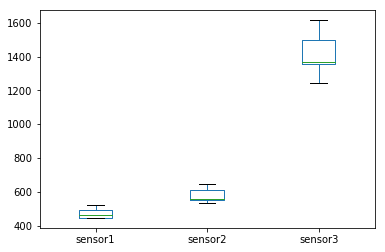

In [272]:
filtered_data = temp_data.filter(temp_data.sensor1 > 400)
x = temp_data[['sensor1']].toPandas()
filtered_data.toPandas().plot(kind='box')

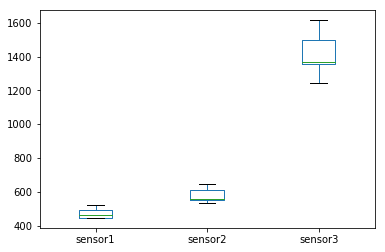

In [273]:
### Filtering directly using SQL
temp_data.createOrReplaceTempView('temp_data_table')

filtered_data = spark.sql('SELECT * FROM temp_data_table WHERE sensor1 > 400')
filtered_data.toPandas().plot(kind='box')

### Example: Descriptive statistics of a selected subset of columns

In [274]:
spark_train_data[['setting1', 'setting2', 'setting3']].describe().show()

+-------+------------------+------------------+------------------+
|summary|          setting1|          setting2|          setting3|
+-------+------------------+------------------+------------------+
|  count|             45918|             45918|             45918|
|   mean|24.008880685192743|0.5712513768381405|49.172437823947035|
| stddev|14.793676185882783|0.3109350404131234| 32.50365903446143|
|    min|               0.0|               0.0|               0.0|
|    max|            42.008|             0.842|             100.0|
+-------+------------------+------------------+------------------+



### Example: Get a list of data column names for the Sensor Only (Not the Settings)

In [275]:
# Note I am using the Spark DataFrame's column property here.
sensor_columns = [tag_name for tag_name in spark_train_data.columns if tag_name.startswith('sensor')]

# Now look at the top 5 rows of the first 8 columns the sensor data
spark_train_data[sensor_columns[0:8]].show(5)

+-------+-------+-------+-------+-------+-------+-------+-------+
|sensor1|sensor2|sensor3|sensor4|sensor5|sensor6|sensor7|sensor8|
+-------+-------+-------+-------+-------+-------+-------+-------+
| 489.05| 604.13|1499.45|1309.95|  10.52|  15.49| 394.88|2318.87|
| 518.67| 642.13|1584.55|1403.96|  14.62|  21.61| 553.67|2388.01|
| 449.44| 555.42|1368.17|1122.49|   5.48|    8.0| 194.93|2222.86|
| 491.19| 607.03|1488.44|1249.18|   9.35|  13.65| 334.82|2323.85|
|  445.0| 549.52|1354.48|1124.32|   3.91|   5.71| 138.24| 2211.8|
+-------+-------+-------+-------+-------+-------+-------+-------+
only showing top 5 rows



### Example: Do a k-means clustering of the settings data

In [276]:
kmeans = KMeans(k=6, seed=1, featuresCol='scaled_settings', predictionCol='prediction')
model = kmeans.fit(scaled_data)

settings_fit_data = model.transform(scaled_data)
settings_fit_data.toPandas().head()

,unit,cycle_num,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,control_settings,scaled_settings,prediction
0,1,1,10.004700,0.2501,20.0,489.049988,604.130005,1499.449951,1309.949951,10.52,15.490000,394.880005,...,2388.129883,8120.830078,8.6216,0.03,368.0,2319.0,100.0,28.580000,17.1735,"[10.004699707, 0.250099986792, 20.0]","[-0.946632926272, -1.03285686174, -0.897512424...",3
1,1,2,0.001500,0.0003,100.0,518.669983,642.130005,1584.550049,1403.959961,14.62,21.610001,553.669983,...,2388.149902,8132.870117,8.3907,0.03,391.0,2388.0,100.0,38.990002,23.3619,"[0.00150000001304, 0.000300000014249, 100.0]","[-1.6228137201, -1.83624005858, 1.5637489343]",1
2,1,3,34.998600,0.8401,60.0,449.440002,555.419983,1368.170044,1122.489990,5.48,8.000000,194.929993,...,2387.949951,8063.839844,9.3557,0.02,334.0,2223.0,100.0,14.830000,8.8555,"[34.9986000061, 0.840099990368, 60.0]","[0.742866018076, 0.864645596625, 0.333118254919]",0
3,1,4,20.003099,0.7005,0.0,491.190002,607.030029,1488.439941,1249.180054,9.35,13.650000,334.820007,...,2388.070068,8052.299805,9.2231,0.02,364.0,2324.0,100.0,24.420000,14.7832,"[20.0030994415, 0.700500011444, 0.0]","[-0.270776593548, 0.415677288845, -1.51282776415]",2
4,1,5,42.004101,0.8405,40.0,445.000000,549.520020,1354.479980,1124.319946,3.91,5.710000,138.240005,...,2387.889893,8083.669922,9.2986,0.02,330.0,2212.0,100.0,10.990000,6.4025,"[42.0041007996, 0.840499997139, 40.0]","[1.21641300568, 0.865932060739, -0.282197084772]",5


### Drop the Individual Settings Columns and Replace with the Existing Columns

In [278]:
cols_to_drop = ['setting1', 'setting2', 'setting3', 'control_settings', 'scaled_settings']
for col in cols_to_drop:
    settings_fit_data = settings_fit_data.drop(col)


In [279]:
settings_fit_data = settings_fit_data.withColumnRenamed('prediction', 'overall_setting')
settings_fit_data.groupBy('overall_setting').count().show()

+---------------+-----+
|overall_setting|count|
+---------------+-----+
|              1| 6954|
|              3| 6882|
|              5|11571|
|              4| 6881|
|              2| 6771|
|              0| 6859|
+---------------+-----+



### Example: Find the sensor data columns that have zero variance, grouped by setting

It might be a good idea to scale the sensors by doing a transformation here such as a z-score transformation. For information on how to do that, look at the documentation in [Spark Feature Extraction](http://spark.apache.org/docs/latest/mllib-feature-extraction.html#standardscaler).  In addition, it would also be good to check for outliers as well, and perhaps remove any rows that have outlier values. Here is an example function that could be used as a simple outlier detection method, that operates on an RDD. Note, that you could do something more complicated here, but I will leave this as an example.

```
def removeOutliers(nums):
    """Remove the outliers"""
    stats = nums.stats()
    stddev = math.sqrt(stats.variance())
    return nums.filter(lambda x: math.fabs(x - stats.mean()) < 3 * stddev)
```

In [280]:
sensor_names = [tag_name for tag_name in settings_fit_data.columns if tag_name.startswith('sensor')]

In [281]:
aggregates = {sensor: "variance" for sensor in sensor_names}
sensor_variance = settings_fit_data.groupBy('overall_setting').agg(aggregates)
sensor_variance.toPandas()

,overall_setting,variance(sensor16),variance(sensor11),variance(sensor15),variance(sensor5),variance(sensor9),variance(sensor20),variance(sensor1),variance(sensor8),variance(sensor2),variance(sensor4),variance(sensor14),variance(sensor7),variance(sensor18),variance(sensor13),variance(sensor19),variance(sensor17),variance(sensor3),variance(sensor12),variance(sensor6),variance(sensor10),variance(sensor21)
0,1,2.984682e-36,0.065961,0.001321,0.0,386.509122,0.030126,0.000000e+00,0.004646,0.233711,76.298153,284.514221,0.731687,0.000000e+00,0.004727,0.0,2.213317,34.736434,0.503660,0.000001,0.000000,0.010910
1,3,2.981347e-36,0.062338,0.001394,0.0,311.781518,0.020827,8.002992e-28,0.008727,0.223580,68.881262,244.896771,0.424718,0.000000e+00,0.009074,0.0,2.139088,33.780962,0.275138,0.000022,0.000000,0.007442
2,5,0.000000e+00,0.054932,0.001360,0.0,326.923798,0.011613,0.000000e+00,0.091081,0.192778,57.060701,276.920977,0.195963,0.000000e+00,0.106020,0.0,1.986615,32.087448,0.117436,0.000024,0.000002,0.004065
3,4,0.000000e+00,0.045964,0.001924,0.0,200.659083,0.012443,0.000000e+00,0.069027,0.124399,48.072774,170.941658,0.200600,1.283250e-26,0.076984,0.0,1.716102,27.529060,0.116541,0.000019,0.000001,0.004497
4,2,1.778954e-05,0.055550,0.001448,0.0,316.451696,0.017761,7.999787e-28,0.016559,0.219272,60.846465,243.971099,0.359788,0.000000e+00,0.017215,0.0,2.056442,33.014961,0.238942,0.000022,0.000018,0.006405
5,0,0.000000e+00,0.052751,0.001454,0.0,296.845931,0.012664,0.000000e+00,0.079950,0.193008,54.446739,242.632680,0.225663,0.000000e+00,0.091973,0.0,1.948452,31.979505,0.143299,0.000003,0.000003,0.004771


In [284]:
zero_variance_columns = (sensor_variance.toPandas() < 0.0001).all(axis=0)
zero_variance_columns.loc[zero_variance_columns]

variance(sensor16)    True
variance(sensor5)     True
variance(sensor1)     True
variance(sensor18)    True
variance(sensor19)    True
variance(sensor6)     True
variance(sensor10)    True
dtype: bool

In [285]:
### Drop the Columns with Zero or Near Zero Variance
drop_columns = ['sensor16', 'sensor5', 'sensor1', 'sensor18', 'sensor19', 'sensor6', 'sensor10']

for column in drop_columns:
    settings_fit_data = settings_fit_data.drop(column)


In [286]:
settings_fit_data.show(5)

+----+---------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+---------------+
|unit|cycle_num|sensor2|sensor3|sensor4|sensor7|sensor8|sensor9|sensor11|sensor12|sensor13|sensor14|sensor15|sensor17|sensor20|sensor21|overall_setting|
+----+---------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+---------------+
|   1|        1| 604.13|1499.45|1309.95| 394.88|2318.87| 8770.2|    45.4|  372.15| 2388.13| 8120.83|  8.6216|   368.0|   28.58| 17.1735|              3|
|   1|        2| 642.13|1584.55|1403.96| 553.67|2388.01|9045.76|   47.29|  521.81| 2388.15| 8132.87|  8.3907|   391.0|   38.99| 23.3619|              1|
|   1|        3| 555.42|1368.17|1122.49| 194.93|2222.86|8343.91|   41.92|  183.26| 2387.95| 8063.84|  9.3557|   334.0|   14.83|  8.8555|              0|
|   1|        4| 607.03|1488.44|1249.18| 334.82|2323.85|8721.53|   44.26|  314.84|

### Example: Calculate and print out a correlation matrix of the sensor data

In [310]:
sensor_names = [tag_name for tag_name in settings_fit_data.columns if tag_name.startswith('sensor')]
settings_fit_data[sensor_names]

vecAssembler = VectorAssembler(inputCols=sensor_names, outputCol="features")
assembled_data = vecAssembler.transform(spark_train_data)

r2 = Correlation.corr(assembled_data, "features", "pearson").collect()
print("Pearson correlation matrix:\n" + str(r2[0]))

Pearson correlation matrix:
Row(pearson(features)=DenseMatrix(14, 14, [1.0, 0.9823, 0.9815, 0.9689, 0.8105, 0.9787, 0.8958, 0.9691, ..., 0.7846, 0.9991, 0.2765, 0.4801, -0.6607, 0.9192, 0.9999, 1.0], False))
